Partial Differential equations (PDEs) are the heart of many physical systems that we are interested in.  We will study three main classes of PDEs
    * Hyperbolic
    * Elliptic
    * Parabolic

$\newcommand{\vec}[1]{{\bf #1}}$
$\newcommand{\ee}{\end{eqnarray}}$
$\newcommand{\dddt}[1]{\frac{\partial^2 #1}{\partial t^2}}$
$\newcommand{\dddx}[1]{\frac{\partial^2 #1}{\partial x^2}}$
$\newcommand{\ddt}[1]{\frac{\partial #1}{\partial t}}$
$\newcommand{\ddx}[1]{\frac{\partial #1}{\partial x}}$


Hyperbolic PDEs characterized by real distinct propagation speeds.  As such their usual physical intepretation involves a state that evolves in time in accordance to a known signal speed. An example of this is the wave equation:
$$
\dddt{f} - \dddx{f} = 0
$$
To solve these equations they require boundary conditions in space and initial conditions in time. The most typical 
example of hyperbolic equations in astronomy are the compressible fluid equations.  

Elliptic PDEs characterized by effectively infinite propagation speeds.  As such they require boundary conditions everywhere as their solution relies on the BCs.  Their solutions are also smooth.  An example of this is the Poisson equation:
$$
\dddt{f} + \dddx{f} = g
$$
In addition to Poisson, other examples of elliptic equation are electrostatics, (Newtonian) gravity, etc.

As a result, the usual method for solving (hyperbolic and parabolic) PDEs is to descretized space and approximate the spatial derivatives on that space and use ODE solvers to advance the solution in time.  There are a number of possible ways to do this. 
    1. finite difference: values of a function are stored at discrete points -- replace derivatives with 
    2. finite volume: the values of a function are average over the volume centered around a grid point.  Because of this, the methods here involve replacing differentiation with integration of a flux over a the boundary of the volume.
    3. finite element: kinda like spectral methods, but with compact basis functions. 
    4. spectral methods: decompose the values of a function on space to Fourier components. Solve for the evolution of the Fourier components. Amazing for smooth flows - exponential convergence.
    5. particle methods: break up space into discrete sampled points the evolve at some velocity -- only really useful for hyperbolic equations.



We will begin first with the linear advection problem as many hyperbolic problems can be rewritten in a manner similar to advection. 
$$
\ddt{f(t,x)} + v\ddx{f(t,x)} = 0,
$$
where $v$ is some propagating speed. We will assume some initial condition $f(0,x)$ and lets assume periodic boundary conditions $f(t,0) = f(t,L)$.  The solution to this problem is trivial: $f(t,x) = g(x-vt)$ for any arbitrary function $g$.  Because such a simple analytic solution exists, these is an ideal test case to test the error of whatever method we bring to bear.

### Finite Difference

The first way we will look at this is via finite difference. Lets try a very simple discretization:
$$
\frac{f^{n+1}_i - f^n_i}{\Delta t} - v\frac{f^n_{i+1} - f^n_{i-1}}{2\Delta x} = 0
$$
This is centered differencing in space and first order differencing in time or FTCS.  For a constant $v$, we can write this as
$$
f^{n+1}_i = f^n_i - \frac{v\Delta t}{2\Delta x}\left(f^n_{i+1} - f^n_{i-1}\right) = f^n_i - \frac{\alpha_{\rm CFL}}{2}\left(f^n_{i+1} - f^n_{i-1}\right),
$$
where $\alpha_{\rm CFL} = v\Delta t/\Delta x$ is called the Courant-Friedrichs-Levy (CFL) number.  

We write a simple code to evolve the advection equations here.  It evolves a simple gaussian or tophat profile across a period box of length $L=1$ at a velocity of $v=1$.  The CFL number is 0.8.  We will present the code later on, but the evolution part looks like this:


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
from IPython import display

cfl = 0.8
v = 1
L = 1
N = 100

dx = L/N
x = np.arange(0,L,dx)

def initial_conditions(x) : 
  N = x.size
  
  f = np.ones(N)*0.5
  f[int(0.25*N):int(0.75*N)] = 1 # top hat profile

  return f

def animate(i,x,frames,xlim=[0,1],ylim=[-2,2],times=None):
    ax.clear()
    f = frames[i]
    ax.plot(x,f, color='green')
    if not times is None :
        ax.text(xlim[1]*0.75,(0.75*ylim[1]+0.25*ylim[0]),"t={0:4.2f}".format(times[i]))
    # Set the x and y axis to display a fixed range
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)



In [3]:
cfl = 0.4
f = initial_conditions(x)


def ftcs(f, dt, dx, cfl=cfl) :
  newf = f 
  newf[1:-1] -= v*(f[2:] - f[0:-2])/(2*dx)*dt
  newf[0] -= v*(f[1] - f[-1])/(2*dx)*dt
  newf[-1] -= v*(f[0] - f[-2])/(2*dx)*dt
  return newf

tend = .25
num_frames = 200
dt = dx/v*cfl

fig, ax = plt.subplots()

frames = []
for t in np.arange(0, tend, dt) : 
    f = ftcs(f, dt, dx) 
    frames.append(f.copy())

ani = FuncAnimation(fig, lambda i : animate(i, x, frames), frames=len(frames), interval=20, repeat=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

If we evolve this, we see that the code appears stable for a little while before it falls apart.  For the tophat profile the situation is dire immediately.  

Now the issue is the FTCS is not stable and in fact it is unconditionally unstable, which is a bad state of affairs.  

To resolve this lets define two first order spatial derivatives
$$
\frac{f^{n+1}_i - f^n_i}{\Delta t} - v\frac{f^n_{i+1} - f^n_{i}}{\Delta x} = 0 \qquad\textrm{for\ } v < 0\\
\frac{f^{n+1}_i - f^n_i}{\Delta t} - v\frac{f^n_{i} - f^n_{i-1}}{\Delta x} = 0 \qquad\textrm{for\ } v > 0 
$$
where we pick the upwind difference, e.g., we look at which way the flow is coming.


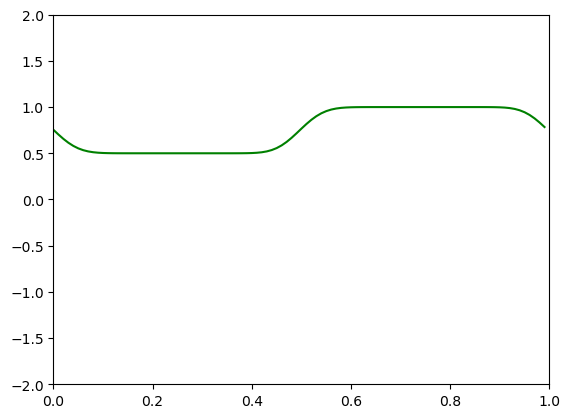

In [4]:
def upwind(f, dt, dx) :
  newf = f 
  newf[1:] -= v*(f[1:] - f[0:-1])/dx*dt
  newf[0] -= v*(f[0] - f[-1])/dx*dt
  return newf

f = initial_conditions(x)

frames = []
for t in np.arange(0, tend, dt) : 
    f = upwind(f, dt, dx) 
    frames.append(f.copy())

fig, ax = plt.subplots()

ani = FuncAnimation(fig, lambda i : animate(i, x, frames), frames=len(frames), interval=20, repeat=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()


## Elliptic Problems

For elliptic problems, the speed of the propagation is infinite and thus responds instantly to any change the source or boundary conditions. For these sorts of problems, relaxation methods work well, but techniques like multigrid can speed things up. 

Lets consider a problem that arises in astrophysics and electrostatics, the Poisson equation
$$
\nabla^2\Phi = f
$$
Let's consider the 1-d version first 
$$
\dddx\Phi = f
$$
with boundary conditions $\Phi(0) = \Phi(1) = 0$.  If we pick $f=\sin(x)$, then we have an analytic solution $\Phi = -\sin(x) +x\sin(1)$.  Given this, how can we solve for this numerically.  

Fortunately, this is an ODE and so the first technique that we will try is using one of our ODE integrators -- say rk2.  Now if we use rk2, we start our and $x=0$ and integrate to $x=1$.  Since $\Phi(x=0) = 0$, we have one initial condition already, but we will need another initial condition for $\Phi'(x=0)$.  We can set this to be a free value, say $\alpha$ and vary it until we get the second boundary condition.  

In other works, lets define a function $g(\alpha)$ such that
$$
g(\alpha) = \Phi(x=1;\alpha),
$$
where $\Phi$ is computed by numerical integration to $x=1$ using $\Phi'(x=0) = \alpha$.  Since we want $g(\alpha) = 0$, this reduces to a root-finding problem for $\alpha$.  So once we define $g(\alpha)$, we can use our root finding routines to find the appropriate value of $\alpha$.  This here is why we define everything as modules. This technique is known as shooting as you are essential shooting until you hit a target.  



In [ ]:
# include newton raphson

Shooting doesn't always work especially with stiff equations which are extremely sensitive to initial conditions.  Examples of this in astrophysics include hydrostatic balance for stars.  In this case, we need to try something different.  Lets discretize the equation to be
$$
\frac{\Phi_{i+1} - 2\Phi_i + \Phi_{i-1}}{\Delta x^2} = f_i,
$$
where we pick $\Phi_0 = \Phi_N = 0$.  We then have a bunch of algebraic equations:
$$
\Phi_i = 0.5\left(\Phi_{i+1} + \Phi_{i-1} - \Delta x^2 f_i\right).
$$
In principle, we can solve with matrix inversion, but it is easier to solve using relaxation starting with some initial guess $\Phi_i^0$  This can use either 
\begin{enumerate}
    \item Jacobi iteration: $\Phi_i^{k+1} = 0.5\left(\Phi_{i+1}^k + \Phi_{i-1}^k - \Delta x^2 f_i\right).$
    \item Gauss-Seidel iteration: Use the new $k+1$ values as they appear. 
\end{enumerate}
In either case, you need to keep track of the error to ensure that the error goes down below some threshold. 


In [6]:
N = 100
L = 1
TINY = 1e-20
MAXERR = 1e-7

def Jacobi(Phi, f) : 
  dx = L/(Phi.size-1)
  Phi[1:-1] = 0.5*(Phi[:-2] + Phi[2:] - dx*dx*f[1:-1])
  return Phi

def error(Phi1, Phi2):
  return np.abs((Phi2-Phi1)[1:-1]/(0.5*np.abs(Phi1+Phi2)+TINY)[1:-1]).sum()

def init() : 
  Phi = np.zeros(N+1)
  dx = L/(Phi.size-1)
  x = np.arange(Phi.size)*dx
  f = np.sin(x)
  return x, Phi, f

x, Phi, f = init()

err = 1
iterations = 0
phi_frames = []
while err > MAXERR :
  iterations += 1
  Phi2 = Phi.copy()
  Phi2 = Jacobi(Phi2, f)
  err = error(Phi,Phi2)
  if( iterations % 100 == 0) :
    phi_frames.append(Phi2.copy())
    #print("Iteration: {0} {1:.3e}".format(iterations, err), Phi2)
  Phi = Phi2

print("Total iteration: {0} {1:.3e}".format(iterations, err))

fig, ax = plt.subplots()
ani = FuncAnimation(fig, lambda i : animate(i, x, phi_frames,ylim=[-0.07,0]), frames=len(phi_frames), interval=20, repeat=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
#plt.scatter(x, Phi,s=1,label="numerical")
#plt.plot(x,-np.sin(x)+x*np.sin(1), label="analytic")
#plt.legend(loc="best")
#plt.show()


Total iteration: 26522 9.999e-08


## Parabolic Problems

As stated above, the parabolic problem has properties of both the hyperbolic and elliptic problem.  In particular, we will see that it can have very large propagation speeds like the elliptic problem, but can be solve in a flux-conservative way as in the hyperbolic problem.  Lets start with a prototypical problem
$$
\ddt{\Phi} = \dddx{\Phi}\label{eq:diffusion}
$$
An identification of the flux to the $F = -\partial\Phi/\partial x$ allows us to write this like the flux-conservative equation
$$
\ddt{\Phi} + \ddx{F} = 0
$$
If we presume the analytic ansatz
$$
\Phi(t,x) = \frac{\exp{-x^2/4t}}{t^{1/2}} + \Phi_0,
$$
we see that it solve the diffusion equation (\ref{eq:diffusion}).  Lets try to solve this problem numerically.  Lets use a standard centered expression for the second derivative in Space
$$
\frac{\Phi^{n+1}_i - \Phi^n_i}{\Delta t} = \frac{\Phi^n_{i+1} - 2\Phi^n_i + \Phi^n_{i-1}}{\Delta x^2}
$$
We can examine its stability in space with a single Fourier mode $\Phi_i^n = A^n\exp(-i2\pi x_i/L)$.  This gives
$$
\left|\frac{A^{n+1}}{A^n}\right| = \left|1 + 2\frac{\Delta t}{\Delta x^2}\left(\cos(2\pi\Delta x/L)-1\right)\right| < 1
$$
which implies that $\Delta t \propto \Delta x^2/2$, e.g., the equivalent ``Courant'' number is $\alpha_{\rm CFL} = 2\Delta t/\Delta x^2$  So the timestep rapidly comes down as $\Delta x$ (higher resolution) shrinks.  

We can numerically solve this once we specific the boundary conditions over a finite domain.  However, we will note that the analytic solution spreads from $x=(-\infty,\infty)$.  However, if we put the boundaries far enough away, it will not ``pollute'' the solution too much in the region of interest.  Here the fact that the timescale goes like $t\sim L^2$ helps. 

Now lets examine the code in detail:


In [8]:
N = 1000
xmax = 10
TINY = 1e-10
MAXERR = 1e-3

def applyBC( phi) : 
  phi[0] = phi[-2]
  phi[-1] = phi[1]

def evolve(Phi, t1, t2, dt, dx) : 
  t = t1
  while(t < t2) : 
    dt = min(dt, t2-t)
    newPhi = Phi.copy()
    dx2 = dx*dx
    newPhi[1:-1] += dt/dx2*(Phi[0:-2] - 2*Phi[1:-1] + Phi[2:])
    applyBC(newPhi)
    Phi = newPhi
    t += dt

  return Phi

def init(N=N,t0=1e-2,Phi0=0.1) : 
  Phi = np.zeros(N+2)
  dx = 2*xmax/N
  x = np.arange(-xmax+dx/2, xmax, dx)
  Phi[1:-1] = np.exp(-np.minimum(x*x/(4*t0),100))/t0**0.5 + Phi0
  applyBC(Phi)
  return x, dx, Phi

In [10]:
x, dx, Phi = init()

iframe = 0
cfl = 0.8
dt = cfl*dx**2*0.5
tstep = 0.1
t = 0
tend = 10
diff_frames = []
times = []
while( t < tend) : 
    Phi = evolve(Phi.copy(), t, t+tstep, dt, dx)
    t += tstep
    times.append(t)
    #print(Phi)
    diff_frames.append(Phi[1:-1].copy())

fig, ax = plt.subplots()
ani = FuncAnimation(fig, lambda i : animate(i, x, diff_frames,xlim=[-xmax,xmax],ylim=[0,2],times=times), frames=len(diff_frames), interval=50, repeat=False)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
               